# Aplicación de un Modelo de Interacción Espacial a datos departamentales

Datos utilizados como variables independientes:

- Población
- Distancias y logaritmo de la distancia entre centros medios de población
- Dummy de límites compartidos
- Largo del límite compartido
- PBI departamental



In [272]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate
from operator import add

from shapely import wkt
from shapely.geometry import shape, LineString, Point
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

In [273]:
# carga datos diádicos
pbi = cargar_pbi()
md = cargar_matriz_distancias()
vecindad = cargar_vecindad()

# carga capas de fatos geográficos
deptos, deptos_sim, localidad, centro_pobl, capital = cargar_datos_geo()

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [274]:
# carga migrantes internos
p_migr = cargar_migrantes_internos()

p_migr.shape[0]

148759

In [275]:
# carga poblacion por depto
pobl = recuperar_poblacion_2011()
pobl.head()

DPTO  poblacion
0     1    1318755
1     2      73377
2     3     520173
3     4      84698
4     5     123203

Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

### El perfil de la migración interna

Algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [276]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head(3)

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387

#### En forma de matriz

In [277]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0,
                        aggfunc=sum,
                        margins=True,
                        margins_name='Total')
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [278]:
# # guarda en csv
# matrix = pd.pivot_table(flujos_deptos,
#                         index ='depto_origen',
#                         columns='depto_destino',
#                         fill_value=0,
#                         aggfunc=sum,
#                         margins=False)

# matrix.to_csv('tablas/matriz_deptos.csv', header=True)

In [279]:
# # guarda en latex
# # lista de nombres deptos para generar tabla en latex
# nomdep = ['Mvdeo.', 'Artigas', 'Can.', 'C. Largo', 'Colonia', 'Durazno',
#           'Flores', 'Florida', 'Lavalleja','Maldonado', 'Paysandú', 'R. Negro', 'Rivera',
#           'Rocha', 'Salto', 'San José', 'Soriano', 'Tacuarembó', 'T. y Tres']

# coddep = np.arange(1, 20, 1).tolist()

# # guarda tabla en latex
# # cabecera = datos_dpto.sort_values('DPTO')['NOMBRE'].to_list()
# # cabecera.append('Total')

# matrix_tex = matrix
# matrix_tex.rename(index=dict(zip(coddep, nomdep)), inplace=True)

# # setea ancho de columnas
# ancho = 'p{0.7cm}'
# colformato='l' + ancho * 20

# matrix_tex.to_latex(buf= "tablas/matriz_orig_dest.tex", bold_rows=False,
#                     column_format = colformato,
#                     caption= 'Matriz de movimientos entre departamentos (Censo INE 2011).')

Se contruye un conjunto de datos que contiene la siguiente información para cada díada de departamentos:
- Los datos son los totales de personas que declaran haber vivido antes en el departamento de origen
- La población total en origen y destino
- El PBI en el departamento de destino y el logaritmo de dicho valor
- La distancia entre cada centro medio de población y el logaritmo de dicho valor

In [280]:
grupo.head()

personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

In [281]:
# unimos todo en un dataframe de díadas

# migrantes
df_agrupado = grupo.reset_index()

# agrega codigo único
df_agrupado.insert(0, 'cod', (df_agrupado['depto_origen'].astype(str)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2)).astype(int))

df_agrupado.head()

cod  depto_origen  depto_destino  personas_mig
0  102             1              2           914
1  103             1              3         33127
2  104             1              4          1387
3  105             1              5          2100
4  106             1              6           982

In [282]:
# pega masas (población!)
df_agrupado = df_agrupado.merge(pobl, how='left', left_on='depto_origen', right_on='DPTO').drop('DPTO', axis=1).rename(columns={'poblacion':'pob_origen'})

df_agrupado = df_agrupado.merge(pobl, how='left', left_on='depto_destino', right_on='DPTO').drop('DPTO', axis=1).rename(columns={'poblacion':'pob_destino'})

df_agrupado.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino
0  102             1              2           914     1318755        73377
1  103             1              3         33127     1318755       520173
2  104             1              4          1387     1318755        84698
3  105             1              5          2100     1318755       123203
4  106             1              6           982     1318755        57084

In [283]:
# pega matriz de distancias
df_agrupado = df_agrupado.merge(md, how='left', on='cod').drop(['cod_ori', 'cod_des'], axis=1).rename(columns={'distancia':'dist'})
df_agrupado.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0  102             1              2           914     1318755        73377   
1  103             1              3         33127     1318755       520173   
2  104             1              4          1387     1318755        84698   
3  105             1              5          2100     1318755       123203   
4  106             1              6           982     1318755        57084   

     dist  
0  610726  
1   22544  
2  393703  
3  172773  
4  198970

In [284]:
# pega datos del PBI
df_agrupado = df_agrupado.merge(pbi, how='left', left_on='depto_origen', right_on='DPTO').drop(['DPTO'], axis=1).rename(columns={'miles_de_pesos':'pbi_origen', 'porcentaje_pbi': 'pbi_porcen_ori'})

df_agrupado = df_agrupado.merge(pbi, how='left', left_on='depto_destino', right_on='DPTO').drop(['DPTO'], axis=1).rename(columns={'miles_de_pesos':'pbi_destino', 'porcentaje_pbi': 'pbi_porcen_des'})

df_agrupado.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0  102             1              2           914     1318755        73377   
1  103             1              3         33127     1318755       520173   
2  104             1              4          1387     1318755        84698   
3  105             1              5          2100     1318755       123203   
4  106             1              6           982     1318755        57084   

     dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  
0  610726   465848031           50,3     14214980            1,5  
1   22544   465848031           50,3     86306492            9,3  
2  393703   465848031           50,3     17048887            1,8  
3  172773   465848031           50,3     43788749            4,7  
4  198970   465848031           50,3     13023942            1,4

In [285]:
# pega vecindad
df_agrupado = df_agrupado.merge(vecindad, how='left', on='cod').drop(['dep1', 'dep2'], axis=1)
df_agrupado['dummy_limit'] = True
df_agrupado.loc[df_agrupado.largo_limite.isnull(), 'dummy_limit'] = False

dd_deptos = df_agrupado

print(df_agrupado.shape)
df_agrupado.head()

(342, 13)


cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0  102             1              2           914     1318755        73377   
1  103             1              3         33127     1318755       520173   
2  104             1              4          1387     1318755        84698   
3  105             1              5          2100     1318755       123203   
4  106             1              6           982     1318755        57084   

     dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  \
0  610726   465848031           50,3     14214980            1,5   
1   22544   465848031           50,3     86306492            9,3   
2  393703   465848031           50,3     17048887            1,8   
3  172773   465848031           50,3     43788749            4,7   
4  198970   465848031           50,3     13023942            1,4   

   largo_limite  dummy_limit  
0           NaN        False  
1       60107.0         True  
2           NaN        False  
3           NaN        False  
4           NaN        False

In [286]:
# calcula logaritmos
def logaritmos(df, variables):
    new_vars = ['log_' + sub for sub in variables]
    nvars = len(variables)
    for i in range(nvars):
        df[new_vars[i]] = np.log(df[variables[i]])
    return df

# definir lista de variables sobre las cuales se quiere el logaritmo
variables = ['pbi_destino', 'dist']

dd_deptos = logaritmos(dd_deptos, variables)

In [287]:
np.log(pd.Series([1,2,3]))

0    0.000000
1    0.693147
2    1.098612
dtype: float64

In [288]:
dd_deptos['log_pbi_destino'] = np.log(dd_deptos.pbi_destino)
dd_deptos['log_dist'] = np.log(dd_deptos.dist)

In [289]:
# decodifica el departamento (códigos INE)
dd_deptos['nom_depto_orig'] = decode_depto(dd_deptos, 'depto_origen')
dd_deptos['nom_depto_des'] = decode_depto(dd_deptos, 'depto_destino')

In [290]:
dd_deptos.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0  102             1              2           914     1318755        73377   
1  103             1              3         33127     1318755       520173   
2  104             1              4          1387     1318755        84698   
3  105             1              5          2100     1318755       123203   
4  106             1              6           982     1318755        57084   

     dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  \
0  610726   465848031           50,3     14214980            1,5   
1   22544   465848031           50,3     86306492            9,3   
2  393703   465848031           50,3     17048887            1,8   
3  172773   465848031           50,3     43788749            4,7   
4  198970   465848031           50,3     13023942            1,4   

   largo_limite  dummy_limit  log_pbi_destino   log_dist nom_depto_orig  \
0           NaN        False        16.469807  13.322404     MONTEVIDEO   
1       60107.0         True        18.273415  10.023224     MONTEVIDEO   
2           NaN        False        16.651595  12.883352     MONTEVIDEO   
3           NaN        False        17.594887  12.059734     MONTEVIDEO   
4           NaN        False        16.382300  12.200909     MONTEVIDEO   

  nom_depto_des  
0       ARTIGAS  
1     CANELONES  
2   CERRO LARGO  
3       COLONIA  
4       DURAZNO

In [291]:
# guarda
dd_deptos.to_csv('tablas/dd_deptos.csv', index=False)

In [292]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica dd_deptos
flows = odflow(dd_deptos,'depto_origen', 'depto_destino', 'personas_mig', deptos, 'cod_ine')

# guarda como geopaquete
# flows.to_file("capas/deptos_mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

In [293]:
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

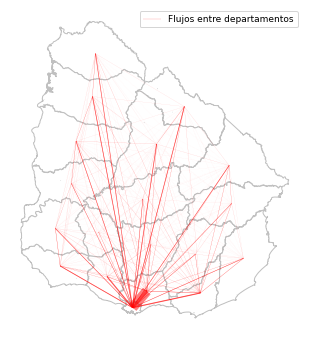

In [294]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color= 'red',
           ax=ax,
           label='Flujos entre departamentos',
           alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# plt.savefig('mapas_graficas/links_depto.pdf',
#            bbox_inches='tight',
#            metadata = metadatos_figs )

Text(0.5, 0, 'Distancia (m)')

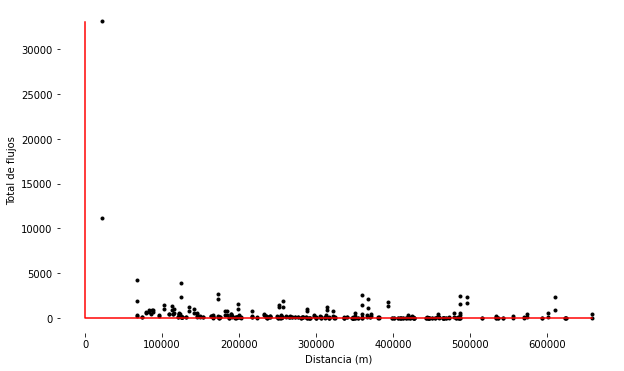

In [295]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(dd_deptos['dist'], dd_deptos['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.0055, dd_deptos['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.

Text(0.5, 0, 'Distancia (m)')

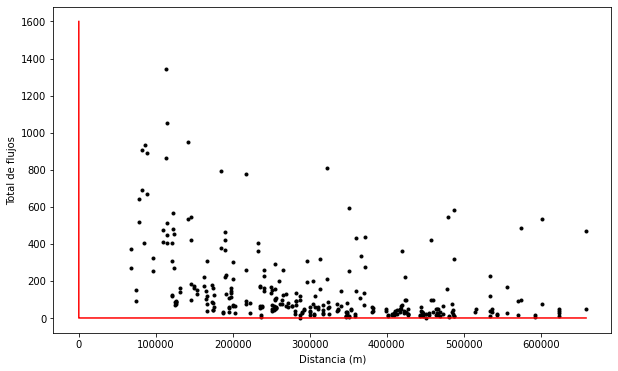

In [296]:
# mismo gráfico sin Mvdeo.
sin_mvo = dd_deptos[(dd_deptos['depto_origen'] > 1) & (dd_deptos['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist'], sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.025, sin_mvo['dist'].max(), 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

Text(0.5, 0, 'Población en origen')

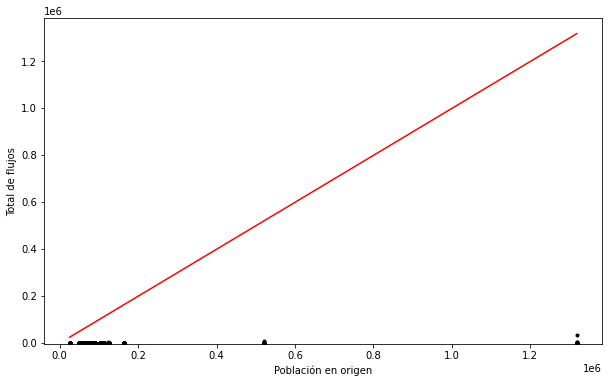

In [297]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(dd_deptos['pob_origen'], dd_deptos['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(dd_deptos['pob_origen'].min(), dd_deptos['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, dd_deptos['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'PBI en destino')

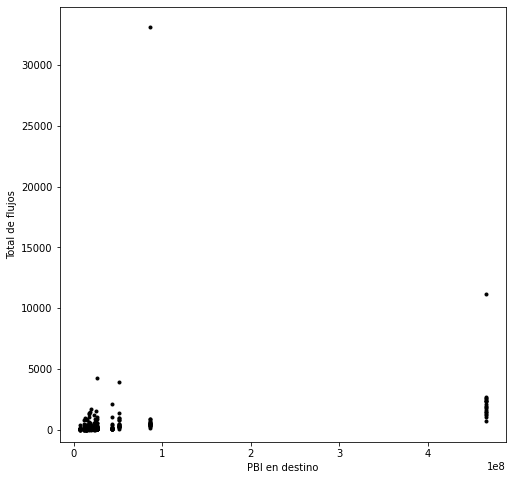

In [298]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(dd_deptos['pbi_destino'], dd_deptos['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(dd_deptos['pbi_destino'].min(), dd_deptos['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, dd_deptos['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

## Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$
3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$

En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson, aplicando el logaritmo, transformando la ecuación 1 en la siguiente:

4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$



In [299]:
# carga datos guardados previamente
# respalda el objeto para usarlo en el otro modelo
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')
dd_deptos_ps.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0  102             1              2           914     1318755        73377   
1  103             1              3         33127     1318755       520173   
2  104             1              4          1387     1318755        84698   
3  105             1              5          2100     1318755       123203   
4  106             1              6           982     1318755        57084   

     dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  \
0  610726   465848031           50,3     14214980            1,5   
1   22544   465848031           50,3     86306492            9,3   
2  393703   465848031           50,3     17048887            1,8   
3  172773   465848031           50,3     43788749            4,7   
4  198970   465848031           50,3     13023942            1,4   

   largo_limite  dummy_limit  log_pbi_destino   log_dist nom_depto_orig  \
0           NaN        False        16.469807  13.322404     MONTEVIDEO   
1       60107.0         True        18.273415  10.023224     MONTEVIDEO   
2           NaN        False        16.651595  12.883352     MONTEVIDEO   
3           NaN        False        17.594887  12.059734     MONTEVIDEO   
4           NaN        False        16.382300  12.200909     MONTEVIDEO   

  nom_depto_des  
0       ARTIGAS  
1     CANELONES  
2   CERRO LARGO  
3       COLONIA  
4       DURAZNO

Especificación del modelo sin intercepto (dado por el valor -1 en la fórmula).

Esto quiere decir que todos lo AiOis son estimados contra in intercepto de 0.

Incluir el intervalo significaría usar el primer departamento en la variable "nom_depto_orig" como intercepto, e interpretar todas las demás categorías con respecto a eso.

In [300]:
# define es string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula= formula, data= dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      321
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14973.
Date:                Mon, 12 Apr 2021   Deviance:                       27718.
Time:                        10:41:50   Pearson chi2:                 3.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]            0.8906      0.075     11.948      0.000       0.745       1.037
nom_depto_orig[CANELONES]          0.3788      0.069      5.491      0.000       0.244       0.514
nom_depto_orig[CERRO LARGO]        0.5190      0.074      6.988      0.000       0.373       0.665
nom_depto_orig[COLONIA]            0.1648      0.073      2.255      0.024       0.022       0.308
nom_depto_orig[DURAZNO]           -0.0837      0.073     -1.140      0.254      -0.227       0.060
nom_depto_orig[FLORES]            -1.0428      0.075    -13.842      0.000      -1.190      -0.895
nom_depto_orig[FLORIDA]           -0.3389      0.073     -4.672      0.000      -0.481      -0.197
nom_depto_orig[LAVALLEJA]         -0.3429      0.073     -4.688      0.000      -0.486      -0.200
nom_depto_orig[MALDONADO]          0.2271      0.073      3.128      0.002       0.085       0.369
nom_depto_orig[MONTEVIDEO]         2.5748      0.067     38.545      0.000       2.444       2.706
nom_depto_orig[PAYSANDU]           0.5033      0.073      6.882      0.000       0.360       0.647
nom_depto_orig[RIO NEGRO]         -0.0120      0.073     -0.164      0.870      -0.156       0.132
nom_depto_orig[RIVERA]             0.7054      0.074      9.489      0.000       0.560       0.851
nom_depto_orig[ROCHA]              0.0459      0.074      0.618      0.537      -0.100       0.192
nom_depto_orig[SALTO]              0.7632      0.074     10.334      0.000       0.618       0.908
nom_depto_orig[SAN JOSE]          -0.4887      0.072     -6.775      0.000      -0.630      -0.347
nom_depto_orig[SORIANO]            0.2470      0.073      3.389      0.001       0.104       0.390
nom_depto_orig[TACUAREMBO]         0.6533      0.074      8.878      0.000       0.509       0.798
nom_depto_orig[TREINTA Y TRES]    -0.0210      0.074     -0.283      0.777      -0.167       0.125
log_pbi_destino                    0.8527      0.002    355.615      0.000       0.848       0.857
log_dist                          -0.7834      0.003   -224.855      0.000      -0.790      -0.777
==================================================================================================
"""

In [301]:
# guarda en latex
prodSim_latex = prodSim.summary().as_latex()
f = open("tablas/prodSim.tex", "w")
f.write(prodSim_latex)
f.close()

In [302]:
# funciones para recuperar parámetros e imprimir
def get_gml_params(model, variables):
    "Accede a los parámetros alfa y beta dentro de los resutaldos del modelo"
    params = [model.params[i] for i in variables]
    params_str = [str(round(i, 4)) for i in params]
    return params, params_str

def print_params(variables, params_list):
    "Imprime los parámetros"
    return print("""alpha ({}) = {}\nbeta ({}) = {}
    """.format(variables[0], params_list[0], variables[1], params_list[1]))

In [303]:
# imprime parámetros
variables= ['log_pbi_destino', 'log_dist']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

alpha (log_pbi_destino) = 0.8527
beta (log_dist) = -0.7834
    


De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de **0,8527**.

El parámetro $\beta$ relativo al decaimiento por la distancia es de **-0,7830**.

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

### Estimación del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación presentada anteriormente:

In [304]:
# imprime la ecuación
eq_str=r'\lambda_{ij} = \exp( \mu_i + ' + params_str[0] + ' ln W_j  +(' + params_str[1] + 'ln d_{ij}))'

printmath(eq_str)

<IPython.core.display.Math object>

In [305]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = dd_deptos_ps.groupby('depto_origen')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = dd_deptos_ps.groupby('depto_destino')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
dd_deptos_ps = dd_deptos_ps.merge(O_i, left_on='depto_origen', right_index=True)
dd_deptos_ps = dd_deptos_ps.merge(D_j, left_on='depto_destino', right_index=True)

dd_deptos_ps.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0   102             1              2           914     1318755        73377   
37  302             3              2            74      520173        73377   
55  402             4              2            15       84698        73377   
73  502             5              2            28      123203        73377   
91  602             6              2            32       57084        73377   

      dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  \
0   610726   465848031           50,3     14214980            1,5   
37  601915    86306492            9,3     14214980            1,5   
55  406694    17048887            1,8     14214980            1,5   
73  556292    43788749            4,7     14214980            1,5   
91  446123    13023942            1,4     14214980            1,5   

    largo_limite  dummy_limit  log_pbi_destino   log_dist nom_depto_orig  \
0            NaN        False        16.469807  13.322404     MONTEVIDEO   
37           NaN        False        16.469807  13.307872      CANELONES   
55           NaN        False        16.469807  12.915816    CERRO LARGO   
73           NaN        False        16.469807  13.229049        COLONIA   
91           NaN        False        16.469807  13.008350        DURAZNO   

   nom_depto_des    O_i   D_j  
0        ARTIGAS  58655  1810  
37       ARTIGAS  17233  1810  
55       ARTIGAS   4459  1810  
73       ARTIGAS   4752  1810  
91       ARTIGAS   3757  1810

In [306]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
dd_deptos_ps = dd_deptos_ps.merge(mu_i, left_on='nom_depto_orig', right_index=True)

In [307]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)

In [308]:
# recupera alpha y beta, previamente guardados en la lista de parámetros
alpha, beta = [i for i in params]

# estima y guarda en columna "podsimtest"
dd_deptos_ps['prodsimest'] = prod_sim_est(dd_deptos_ps, variables, alpha, beta)

In [309]:
dd_deptos_ps['prodsimest'].head()

0      484.0
1    29872.0
2      797.0
3     3397.0
4     1081.0
Name: prodsimest, dtype: float64

In [310]:
# matriz de flujos estimada por el modelo
dd_deptos_ps['depto_origen'] = dd_deptos_ps.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(dd_deptos_ps,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

depto_destino      1     2      3     4     5     6     7     8     9    10  \
depto_origen                                                                  
1                  0   484  29872   797  3397  1081   705  2378  1714  5034   
2               1761     0    423   144   252   107    64   121    99   253   
3              14004    54      0    93   351   125    81   297   216   602   
4               1713    85    426     0   198   107    54   120   128   305   
5               2291    47    505    62     0    97    85   129    86   229   
6               1601    43    394    74   212     0   100   145    87   197   
7                657    16    162    24   117    63     0    54    30    73   
8               2092    29    557    49   168    86    51     0    95   217   
9               1679    27    451    58   125    58    31   106     0   362   
10              3157    44    805    89   212    84    49   155   234     0   
11              1778   105    429    91   319   112    87   125    88   228   
12              1200    53    286    51   255    71    57    79    55   145   
13              1722   207    415   181   234   110    64   121   100   248   
14              1513    38    383    89   141    63    34    93   123   363   
15              1851   202    445   122   306   114    77   126    94   248   
16              2502    24    505    36   207    56    46   116    65   168   
17              1824    60    435    68   456   107    92   115    80   211   
18              2103   140    509   167   287   158    88   157   118   284   
19              1274    44    323   162   128    75    37    91   110   243   
Total          44722  1702  37325  2357  7365  2674  1802  4528  3522  9410   

depto_destino    11    12    13    14    15    16    17    18    19   Total  
depto_origen                                                                 
1              1237  1285   769  1159   953  4712  1438   900   739   58654  
2               266   206   337   106   378   163   173   219    92    5164  
3               140   144    87   137   107   445   161   102    88   17234  
4               137   117   173   147   135   144   115   153   202    4459  
5               150   184    70    73   106   263   242    83    50    4752  
6               115   113    73    71    87   156   125   100    65    3758  
7                56    57    27    24    37    80    67    35    20    1599  
8                77    74    48    63    57   192    80    59    47    4041  
9                60    57    44    93    47   120    61    49    62    3490  
10              100    97    69   174    80   198   104    76    88    5815  
11                0   480   130    81   355   180   283   155    65    5091  
12              312     0    71    50   145   124   307    82    40    3383  
13              203   170     0   110   222   161   144   282   104    4798  
14               73    70    64     0    63   119    72    65    99    3465  
15              481   302   193    93     0   181   230   205    80    5350  
16               67    71    38    48    49     0    82    46    32    4158  
17              249   418    81    70   150   197     0    97    55    4765  
18              253   205   295   116   247   201   178     0   105    5611  
19               78    73    80   130    71   104    74    77     0    3174  
Total          4054  4123  2649  2745  3289  7740  3936  2785  2033  148761

In [311]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [312]:
# se define este diccionario para recodificar el índice, con abreviaturas
deptos_dict = {
    1:	'Mvdeo.',
    2:	'Artigas',
    3:	'Can.',
    4:	'C. Largo',
    5:	'Colonia',
    6:	'Durazno',
    7:	'Flores',
    8:	'Florida',
    9:	'Lavalleja',
    10:	'Maldonado',
    11:	'Paysandú',
    12:	'R. Negro',
    13:	'Rivera',
    14:	'Rocha',
    15:	'Salto',
    16:	'San José',
    17:	'Soriano',
    18:	'Tacuarembó',
    19:	'T. y Tres'
        }

In [313]:
# se determina el formato de columnas para exportación en latex
def format_cols_latex(ancho, ncols):
    colformato = 'lp{' + ancho + 'cm}' + ('p{' + ancho + 'cm}') * ncols
    return colformato

colformato = format_cols_latex('0.7', 19 )

In [314]:
# exporta a latex
matrix_prodsim_tex = matrix_prodsim.rename(index=deptos_dict)

matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex",
bold_rows=False,
column_format = colformato,
float_format="%.2f",
caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [315]:
# bondad de ajuste

# define una función para calcular el R cuadrado
def calcR2(obs, est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# define una función para calcula el error medio cuadrático
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

In [316]:
printmd('**Bondad de ajuste del modelo restringido en origen**')

printmd("$R²$ = " + round(calcR2(dd_deptos_ps['personas_mig'],dd_deptos_ps['prodsimest']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(dd_deptos_ps['personas_mig'],dd_deptos_ps['prodsimest']), 4).astype(str))


**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9738

RMSE = 322.431

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

In [317]:
# Modelo de restricción doble

# recupera los datos del respaldo
dd_deptos_dc =  pd.read_csv('tablas/dd_deptos.csv')

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’  which means that an intercept will appear in the model again. This is not because I want an intercept as it makes the origin and destination coefficients harder to interpret - reference categories zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist"

doubSim = smf.glm(formula=formula, data = dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12551.
Date:                Mon, 12 Apr 2021   Deviance:                       22874.
Time:                        10:41:51   Pearson chi2:                 2.48e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0557      0.018      3.137      0.002       0.021       0.091
nom_depto_orig[T.CANELONES]         -0.2652      0.019    -13.633      0.000      -0.303      -0.227
nom_depto_orig[T.CERRO LARGO]       -0.3530      0.021    -17.210      0.000      -0.393      -0.313
nom_depto_orig[T.COLONIA]           -0.6452      0.020    -31.665      0.000      -0.685      -0.605
nom_depto_orig[T.DURAZNO]           -0.8956      0.022    -41.301      0.000      -0.938      -0.853
nom_depto_orig[T.FLORES]            -1.8378      0.029    -63.650      0.000      -1.894      -1.781
nom_depto_orig[T.FLORIDA]           -1.1349      0.022    -52.545      0.000      -1.177      -1.093
nom_depto_orig[T.LAVALLEJA]         -1.1729      0.022    -52.395      0.000      -1.217      -1.129
nom_depto_orig[T.MALDONADO]         -0.5582      0.020    -28.488      0.000      -0.597      -0.520
nom_depto_orig[T.MONTEVIDEO]         1.7104      0.017    103.476      0.000       1.678       1.743
nom_depto_orig[T.PAYSANDU]          -0.3186      0.020    -16.024      0.000      -0.358      -0.280
nom_depto_orig[T.RIO NEGRO]         -0.8202      0.022    -36.774      0.000      -0.864      -0.776
nom_depto_orig[T.RIVERA]            -0.1702      0.020     -8.456      0.000      -0.210      -0.131
nom_depto_orig[T.ROCHA]             -0.8116      0.022    -36.687      0.000      -0.855      -0.768
nom_depto_orig[T.SALTO]             -0.0802      0.020     -4.090      0.000      -0.119      -0.042
nom_depto_orig[T.SAN JOSE]          -1.2430      0.022    -57.139      0.000      -1.286      -1.200
nom_depto_orig[T.SORIANO]           -0.5496      0.020    -27.059      0.000      -0.589      -0.510
nom_depto_orig[T.TACUAREMBO]        -0.1954      0.019    -10.085      0.000      -0.233      -0.157
nom_depto_orig[T.TREINTA Y TRES]    -0.8797      0.023    -38.760      0.000      -0.924      -0.835
nom_depto_des[T.CANELONES]           0.2298      0.029      7.999      0.000       0.173       0.286
nom_depto_des[T.CERRO LARGO]         0.1919      0.030      6.419      0.000       0.133       0.250
nom_depto_des[T.COLONIA]            -0.3190      0.028    -11.346      0.000      -0.374      -0.264
nom_depto_des[T.DURAZNO]            -0.0632      0.031     -2.056      0.040      -0.123      -0.003
nom_depto_des[T.FLORES]             -0.3382      0.036     -9.372      0.000      -0.409      -0.267
nom_depto_des[T.FLORIDA]            -0.3175      0.030    -10.708      0.000      -0.376      -0.259
nom_depto_des[T.LAVALLEJA]          -0.3194      0.031    -10.351      0.000      -0.380      -0.259
nom_depto_des[T.MALDONADO]           0.2724      0.027     10.262      0.000       0.220       0.324
nom_depto_des[T.MONTEVIDEO]         -0.0855      0.03

In [318]:
# guarda DF para enviar a Eugenia
#dd_deptos_dc.head()
#dd_deptos_dc.to_csv('tablas/dd_deptos_dc.csv', index=False)

In [319]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [320]:
# recupera los valores estimados
dd_deptos_dc['doubsim_ajustado'] = np.round(doubSim.predict())

dd_deptos_dc['depto_origen'] = dd_deptos_dc.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(dd_deptos_dc,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

depto_destino      1     2      3     4     5     6     7     8     9     10  \
depto_origen                                                                   
1                  0   518  31740  1002  2410  1005   496  1633  1199   6301   
2               1665     0    551   177   189   102    47    91    75    346   
3              13455    73      0   145   312   144    71   251   186    933   
4               1600    88    546     0   149   101    40    89    93    405   
5               2150    52    658    83     0    95    61    98    67    321   
6               1514    48    512    95   160     0    69   106    66    274   
7                628    19    212    32    87    58     0    41    23    104   
8               1919    33    697    65   128    83    38     0    71    297   
9               1517    30    556    74    95    55    23    76     0    457   
10              2968    51   1037   119   169    86    39   119   172      0   
11              1738   112    578   121   243   110    64    97    70    327   
12              1177    58    387    69   192    71    42    62    44    209   
13              1629   200    540   217   176   105    47    91    75    340   
14              1391    41    482   110   107    60    25    69    88    461   
15              1806   203    598   158   234   113    57    98    74    353   
16              2323    28    656    50   160    57    35    89    52    242   
17              1784    67    586    92   336   106    67    90    64    304   
18              1998   144    666   206   217   149    64   117    89    393   
19              1181    46    410   188    97    71    27    67    78    318   
Total          42443  1811  41412  3003  5461  2571  1312  3284  2586  12385   

depto_destino    11    12    13    14    15    16    17    18    19   Total  
depto_origen                                                                 
1              1091   899   957  1265  1118  4018  1029  1137   839   58657  
2               226   142   378   120   404   158   125   263   105    5164  
3               154   125   134   186   157   480   143   161   123   17233  
4               121    84   204   159   156   138    85   188   213    4459  
5               136   131    92    87   129   247   173   110    62    4752  
6               104    82    93    83   105   150    92   128    76    3757  
7                51    41    35    29    45    76    49    46    24    1600  
8                71    55    63    73    71   180    61    78    56    4039  
9                55    42    56   101    58   114    46    64    70    3489  
10               97    75    94   198   103   197    83   105   106    5818  
11                0   318   165    97   395   179   203   199    80    5096  
12              261     0    92    60   169   123   212   108    49    3385  
13              176   119     0   124   249   155   106   331   118    4798  
14               67    51    80     0    75   113    54    83   108    3465  
15              401   209   236   111     0   179   168   257    96    5351  
16               65    54    53    59    64     0    65    64    41    4157  
17              221   281   108    85   180   194     0   130    68    4763  
18              220   144   342   133   279   194   132     0   121    5608  
19               70    53    97   138    84    99    55    97     0    3176  
Total          3587  2905  3279  3108  3841  6994  2881  3549  2355  148767

In [321]:
matrix_doubsim_tex = matrix_doubsim.rename(index=deptos_dict)

colformato = format_cols_latex('0.7', 19 )

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [322]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [323]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(dd_deptos_dc['personas_mig'],  dd_deptos_dc['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado']), 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3925

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

### Versión iterativa para calcular los factores de balance

Se toma la siguiente función, desarrollada por XXX basado en Dennet.
Los inputs son:

- df: un dataframe de pandas con los flújos diádicos

- orig_field: nombre del campo con las etiquetas de los origenes

- dest_field: nombre del campo con las etiquetas de los destinos

- Oi_field: nombre del campo con los flujos totales dado un origen $i$

- Dj_field: nombre del campo con los flujos totales dado a un destino $j$

- cij_field: nombre del campo con los costos diádicos (ej.: distancia) entre $i$ y $j$

- beta: constante

- cost_function: un texto que identifica la función de costo ('power' o 'exponential')

- Ainame: nombre del nuevo campo en el cual se guardarán los valores $A_{i}$, con valores por defecto "Ai_new"

- Bjname: nombre del nuevo campo en el cual se guardarán los valores $B_{j}$, con valores por defecto "Bj_new"

- converge: un umbral llegado al cual podemos afirmar que el modelo convergió, por defecto es 0.001


$O_{i}$ and $D_{j}$ son los totales de flujos por origen o destino, calculados previamente.

La función representa el abordaje maximizador de la entropía para un beta conocido.

fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb

In [333]:
dd_deptos_dc.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0   102             1              2           914     1318755        73377   
37  302             3              2            74      520173        73377   
55  402             4              2            15       84698        73377   
73  502             5              2            28      123203        73377   
91  602             6              2            32       57084        73377   

      dist  pbi_origen pbi_porcen_ori  pbi_destino  ... log_pbi_destino  \
0   610726   465848031           50,3     14214980  ...       16.469807   
37  601915    86306492            9,3     14214980  ...       16.469807   
55  406694    17048887            1,8     14214980  ...       16.469807   
73  556292    43788749            4,7     14214980  ...       16.469807   
91  446123    13023942            1,4     14214980  ...       16.469807   

     log_dist  nom_depto_orig  nom_depto_des  doubsim_ajustado    O_i   D_j  \
0   13.322404      MONTEVIDEO        ARTIGAS             518.0  58655  1810   
37  13.307872       CANELONES        ARTIGAS              73.0  17233  1810   
55  12.915816     CERRO LARGO        ARTIGAS              88.0   4459  1810   
73  13.229049         COLONIA        ARTIGAS              52.0   4752  1810   
91  13.008350         DURAZNO        ARTIGAS              48.0   3757  1810   

      Ai_new    Bj_new  SIM_est_pow  
0   0.000062  0.896051        930.0  
37  0.000044  0.896051        195.0  
55  0.000039  0.896051         46.0  
73  0.000038  0.896051         47.0  
91  0.000038  0.896051         37.0  

[5 rows x 23 columns]

In [325]:
# basado en: https://journals.sagepub.com/doi/abs/10.1177/030913257900300218
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(df, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = df[[orig_field, Oi_field]]
    Dj = df[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(df[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * df[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    df[Ai_name] = Oi['Ai_old']
    df[Bj_name] = Dj['Bj_old']
    return df

In [326]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = dd_deptos_dc.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = dd_deptos_dc.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
dd_deptos_dc = dd_deptos_dc.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
dd_deptos_dc = dd_deptos_dc.merge(D_j,left_on='depto_destino', right_index=True)

dd_deptos_dc.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0   102             1              2           914     1318755        73377   
37  302             3              2            74      520173        73377   
55  402             4              2            15       84698        73377   
73  502             5              2            28      123203        73377   
91  602             6              2            32       57084        73377   

      dist  pbi_origen pbi_porcen_ori  pbi_destino pbi_porcen_des  \
0   610726   465848031           50,3     14214980            1,5   
37  601915    86306492            9,3     14214980            1,5   
55  406694    17048887            1,8     14214980            1,5   
73  556292    43788749            4,7     14214980            1,5   
91  446123    13023942            1,4     14214980            1,5   

    largo_limite  dummy_limit  log_pbi_destino   log_dist nom_depto_orig  \
0            NaN        False        16.469807  13.322404     MONTEVIDEO   
37           NaN        False        16.469807  13.307872      CANELONES   
55           NaN        False        16.469807  12.915816    CERRO LARGO   
73           NaN        False        16.469807  13.229049        COLONIA   
91           NaN        False        16.469807  13.008350        DURAZNO   

   nom_depto_des  doubsim_ajustado    O_i   D_j  
0        ARTIGAS             518.0  58655  1810  
37       ARTIGAS              73.0  17233  1810  
55       ARTIGAS              88.0   4459  1810  
73       ARTIGAS              52.0   4752  1810  
91       ARTIGAS              48.0   3757  1810

In [327]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta = doubSim.params[-1]
beta

-0.7134885292653599

In [334]:
# recupera factores de balance
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'log_dist',
beta,
'pow',
Ai_name = "Ai_new",
Bj_name = "Bj_new",
converge=0.00001)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13


In [335]:
dd_deptos_dc.head()

cod  depto_origen  depto_destino  personas_mig  pob_origen  pob_destino  \
0   102             1              2           914     1318755        73377   
37  302             3              2            74      520173        73377   
55  402             4              2            15       84698        73377   
73  502             5              2            28      123203        73377   
91  602             6              2            32       57084        73377   

      dist  pbi_origen pbi_porcen_ori  pbi_destino  ... log_pbi_destino  \
0   610726   465848031           50,3     14214980  ...       16.469807   
37  601915    86306492            9,3     14214980  ...       16.469807   
55  406694    17048887            1,8     14214980  ...       16.469807   
73  556292    43788749            4,7     14214980  ...       16.469807   
91  446123    13023942            1,4     14214980  ...       16.469807   

     log_dist  nom_depto_orig  nom_depto_des  doubsim_ajustado    O_i   D_j  \
0   13.322404      MONTEVIDEO        ARTIGAS             518.0  58655  1810   
37  13.307872       CANELONES        ARTIGAS              73.0  17233  1810   
55  12.915816     CERRO LARGO        ARTIGAS              88.0   4459  1810   
73  13.229049         COLONIA        ARTIGAS              52.0   4752  1810   
91  13.008350         DURAZNO        ARTIGAS              48.0   3757  1810   

      Ai_new    Bj_new  SIM_est_pow  
0   0.000062  0.896051        930.0  
37  0.000044  0.896051        195.0  
55  0.000039  0.896051         46.0  
73  0.000038  0.896051         47.0  
91  0.000038  0.896051         37.0  

[5 rows x 23 columns]

In [336]:
# Now predict the model again using the new Ai and Dj fields.
dd_deptos_dc['SIM_est_pow'] = np.round(dd_deptos_dc['O_i'] * dd_deptos_dc['Ai_new'] * dd_deptos_dc['D_j'] * dd_deptos_dc['Bj_new'] * 
                                       np.exp(np.log(dd_deptos_dc['log_dist'])*beta))


In [337]:
# Check out the matrix
pd.pivot_table(dd_deptos_dc,
values='SIM_est_pow',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True)

depto_destino      1     2      3     4     5     6     7     8     9     10  \
depto_origen                                                                   
1                  0   930  24855  1544  2855  1326   668  1721  1345   6569   
2               2241     0   1148    87   151    72    36    88    70    338   
3              10155   195      0   324   594   278   140   363   284   1382   
4               1953    46   1003     0   130    63    31    77    62    299   
5               2135    47   1087    77     0    67    34    83    65    313   
6               1650    37    847    62   111     0    28    67    51    246   
7                697    16    358    26    48    23     0    28    21    103   
8               1799    38    930    64   116    56    28     0    55    264   
9               1541    33    797    56    99    47    23    60     0    240   
10              2727    58   1404    98   174    82    41   105    87      0   
11              2235    53   1146    84   153    72    37    88    69    334   
12              1481    34    758    55   103    47    24    58    46    220   
13              2101    52   1077    83   141    67    34    83    66    317   
14              1526    34    785    58   100    47    24    60    49    239   
15              2350    58   1204    90   160    75    38    93    73    353   
16              1914    40    967    65   124    57    29    73    56    272   
17              2090    48   1071    77   147    67    34    82    64    310   
18              2463    59   1263    96   166    80    40    98    77    370   
19              1388    32    714    56    91    44    22    55    45    214   
All            42446  1810  41414  3002  5463  2570  1311  3282  2585  12383   

depto_destino    11    12    13    14    15    16    17    18    19       All  
depto_origen                                                                   
1              1846  1483  1682  1605  1977  3716  1490  1834  1207   58653.0  
2               105    83   101    86   118   185    82   106    66    5163.0  
3               387   310   352   337   414   767   312   384   254   17232.0  
4                88    70    84    77    96   160    69    90    61    4459.0  
5                95    77    85    78   101   180    78    92    59    4753.0  
6                74    59    67    62    79   137    59    74    48    3758.0  
7                32    25    28    26    33    59    26    31    20    1600.0  
8                76    61    70    66    82   149    61    76    50    4041.0  
9                65    52    60    59    70   125    52    65    45    3489.0  
10              115    92   105   104   123   219    92   114    77    5817.0  
11                0    88    94    84   117   186    85   103    65    5093.0  
12               73     0    61    56    75   123    58    67    42    3381.0  
13               97    77     0    81   107   174    76   101    63    4797.0  
14               66    53    62     0    72   125    53    67    46    3466.0  
15              115    89   102    89     0   195    87   110    69    5350.0  
16               79    64    72    68    85     0    64    78    51    4158.0  
17               98    82    85    78   103   175     0    93    60    4764.0  
18              114    90   109    94   124   204    89     0    73    5609.0  
19               61    49    58    56    66   114    49    62     0    3176.0  
All            3586  2904  3277  3106  3842  6993  2882  3547  2356  148759.0

In [338]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado']), 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3925

In [ ]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# graficar logaritmo de los flujos vs logaritmo de la distancia

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.
# And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased.


# modelar con binomial negativa

